In [50]:
# Individual reporting description initialisation
# Student Name - Saroj Khanal
#Student ID - s378199
#Unit Name and code -  MACHINE LEARNING, ARTIFICIAL INTELLIGENCE AND ALGORITHMS, PRT565
# Assignment 2 - ASSESSMENT 2: MACHINE LEARNING CODING EXERCISE
#TITLE: TESLA STOCK PRICE PREDICTION

import os
import math
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (train_test_split, GridSearchCV, TimeSeriesSplit)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report,
    roc_curve )
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

import joblib
np.random.seed(42)

In [52]:
WORK_DIR = os.getcwd()
DATA_FILE = "Tesla.csv"   # place your CSV here


print("Working directory:", WORK_DIR)

# Load CSV file into a DataFrame
data = pd.read_csv("Tesla.csv")
data.sort_values('Date', inplace=True)
# Show the first 5 rows
data.head()


Working directory: C:\Users\saroj


,Date,Open,High,Low,Close,Volume,Adj Close
135,1/10/2011,28.170000,28.680000,28.049999,28.450001,1342700,28.450001
387,1/10/2012,27.440001,27.760000,27.250000,27.620001,671800,27.620001
638,1/10/2013,33.869999,33.990002,33.380001,33.529999,922500,33.529999
890,1/10/2014,148.460007,148.899994,142.250000,145.720001,7446100,145.720001
1645,1/10/2017,232.000000,232.000000,226.889999,229.869995,3660000,229.869995


Missing values:
 Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64


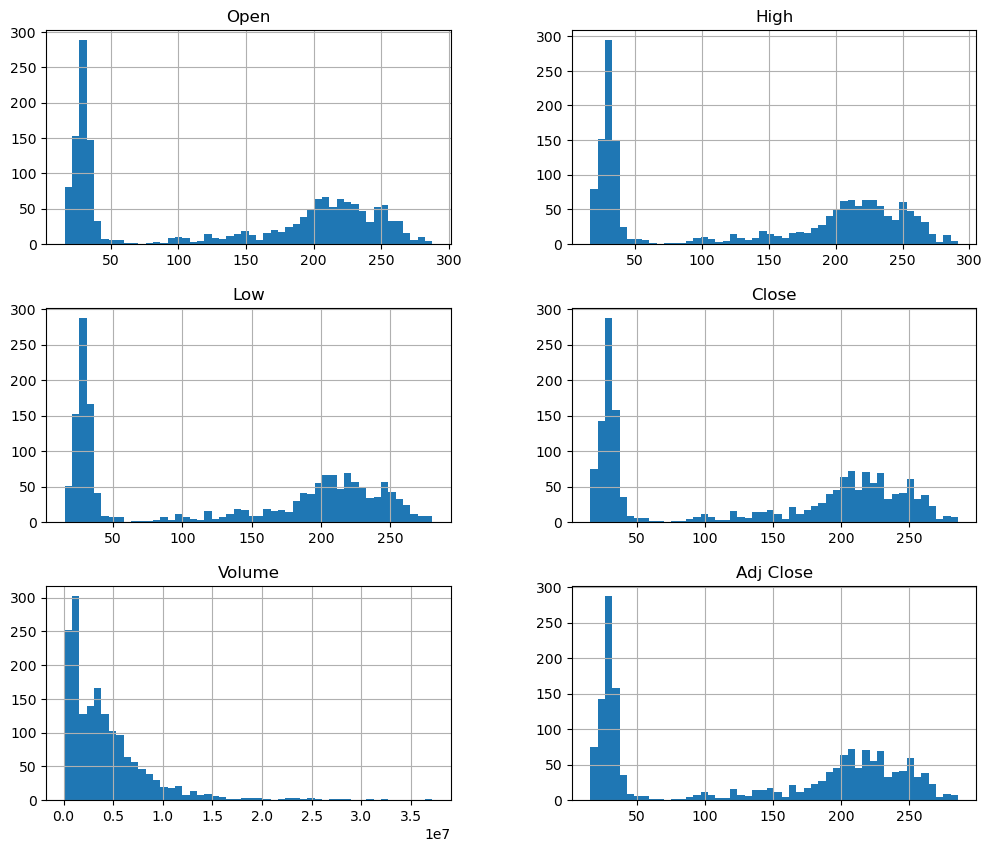

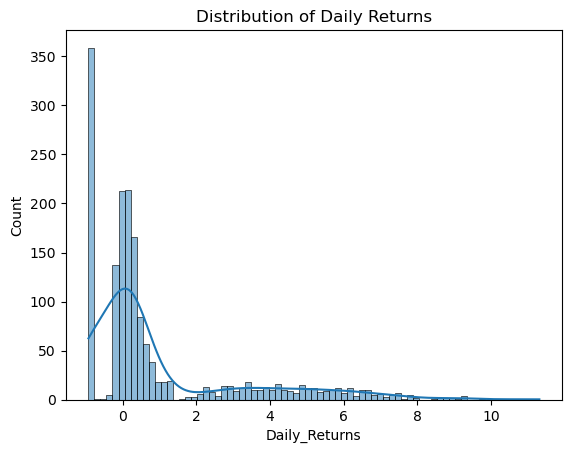

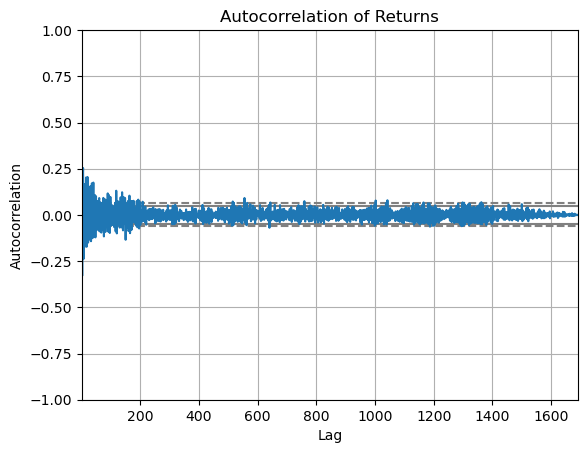

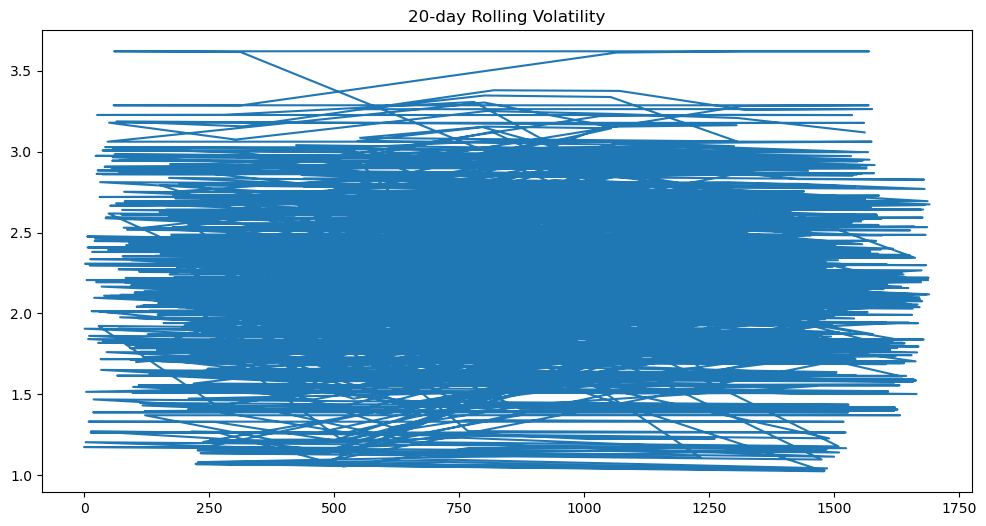

In [53]:
# Null values per feature
print("Missing values:\n", data.isnull().sum())

# Histograms of features
data.hist(figsize=(12,10), bins=50)
plt.show()

# Daily returns distribution
data['Daily_Returns'] = data['Close'].pct_change()
sns.histplot(data['Daily_Returns'].dropna(), kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

# Autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Daily_Returns'].dropna())
plt.title("Autocorrelation of Returns")
plt.show()

# Volatility over time
data['Volatility'] = data['Daily_Returns'].rolling(20).std()
data['Volatility'].plot(figsize=(12,6), title="20-day Rolling Volatility")
plt.show()

In [17]:
data.columns = data.columns.str.strip()
data['Date'] = pd.to_datetime(data['Date'], errors='raise')
data = data.sort_values('Date').reset_index(drop=True)

print("Data shape:", data.shape)
display(data.head())



Data shape: (1692, 9)


,Date,Open,High,Low,Close,Volume,Adj Close,Daily_Returns,Volatility
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999,-0.881610,1.174011
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000,-0.891182,1.905720
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999,-0.904255,2.306821
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001,-0.914765,1.203902
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001,-0.924713,1.515294


Date range: 1/10/2011 to 9/9/2016
Null counts per column:


Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Adj Close         0
Daily_Returns     1
Volatility       20
dtype: int64


Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
Open,1692.0,1.324416e+02,9.430992e+01,16.139999,3.000000e+01,1.563350e+02,2.205575e+02,2.876700e+02
High,1692.0,1.347697e+02,9.569491e+01,16.629999,3.065000e+01,1.623700e+02,2.241000e+02,2.914200e+02
Low,1692.0,1.299962e+02,9.285523e+01,14.980000,2.921500e+01,1.531500e+02,2.171200e+02,2.804000e+02
Close,1692.0,1.324287e+02,9.431319e+01,15.800000,2.988500e+01,1.581600e+02,2.200225e+02,2.860400e+02
Volume,1692.0,4.270741e+06,4.295971e+06,118500.000000,1.194350e+06,3.180700e+06,5.662100e+06,3.716390e+07
Adj Close,1692.0,1.324287e+02,9.431319e+01,15.800000,2.988500e+01,1.581600e+02,2.200225e+02,2.860400e+02
Daily_Returns,1691.0,9.590790e-01,2.223513e+00,-0.927505,-1.686024e-01,1.618273e-01,8.137008e-01,1.131556e+01
Volatility,1672.0,2.214591e+00,4.651121e-01,1.024212,1.927634e+00,2.212187e+00,2.521664e+00,3.621026e+00


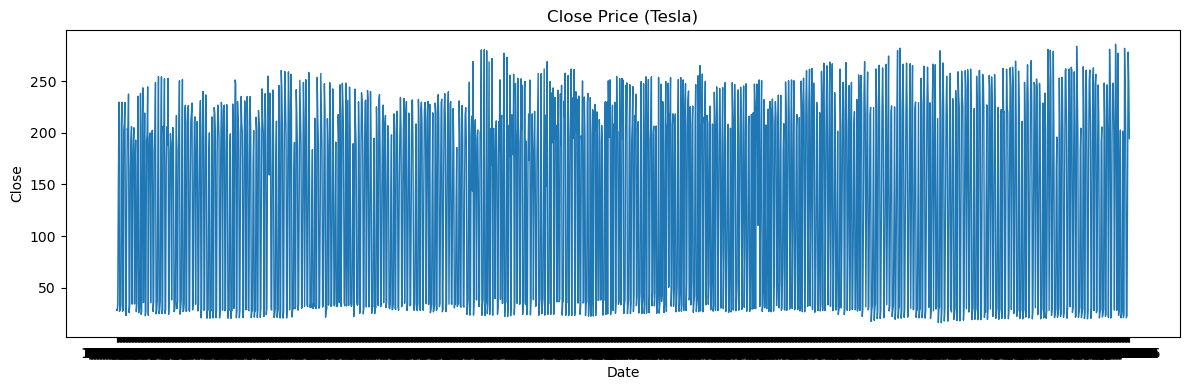

In [54]:
print("Date range:", data['Date'].min(), "to", data['Date'].max())
print("Null counts per column:")
display(data.isna().sum())

print("\nDescriptive statistics:")
display(data.drop(columns=['Date']).describe().T)

plt.figure(figsize=(12,4))
plt.plot(data['Date'], data['Close'], lw=1)
plt.title("Close Price (Tesla)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()

In [56]:
data = pd.read_csv('Tesla.csv', parse_dates=['Date'])
xeroxdata = data.copy()

# Basic returns
xeroxdata['Return'] = xeroxdata['Close'].pct_change()              # current day's pct change (Close_t / Close_{t-1} - 1)
xeroxdata['LogReturn'] = np.log(xeroxdata['Close']).diff()

# Lag returns
for lag in [1,2,3,5]:
    xeroxdata[f'Return_lag_{lag}'] = xeroxdata['Return'].shift(lag)

# Rolling stats: SMA and rolling std
for win in [5,10,20]:
    xeroxdata[f'SMA_{win}'] = xeroxdata['Close'].rolling(window=win, min_periods=1).mean()
    xeroxdata[f'RollStd_{win}'] = xeroxdata['Close'].rolling(window=win, min_periods=1).std()
    xeroxdata[f'Close_minus_SMA_{win}'] = xeroxdata['Close'] - xeroxdata[f'SMA_{win}']

# Momentum and other features
xeroxdata['Momentum_5'] = xeroxdata['Close'] - xeroxdata['Close'].shift(5)
xeroxdata['High-Low'] = xeroxdata['High'] - xeroxdata['Low']

# Volume features
xeroxdata['Volume_change'] = xeroxdata['Volume'].pct_change()
for win in [5,10]:
    xeroxdata[f'Volume_SMA_{win}'] = xeroxdata['Volume'].rolling(window=win, min_periods=1).mean()

# Day of week feature (0=Mon..6=Sun)
xeroxdata['DayOfWeek'] = xeroxdata['Date'].dt.dayofweek

In [57]:
# Optional: simple RSI calculation (14-period)
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

xeroxdata['RSI_14'] = compute_rsi(xeroxdata['Close'], window=14)

In [58]:
# --- Additional Technical Indicators ---



# Exponential Moving Averages (EMAs)
for window in [5, 10, 20, 50]:
    data[f'EMA_{window}'] = data['Close'].ewm(span=window, adjust=False).mean()

# Moving Average Convergence Divergence (MACD)
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20-day)
data['SMA_20'] = data['Close'].rolling(20).mean()
data['BB_up'] = data['SMA_20'] + 2*data['Close'].rolling(20).std()
data['BB_dn'] = data['SMA_20'] - 2*data['Close'].rolling(20).std()

# Stochastic Oscillator
low14 = data['Low'].rolling(14).min()
high14 = data['High'].rolling(14).max()
data['Stochastic_%K'] = (data['Close'] - low14) * 100 / (high14 - low14)
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(3).mean()

# Average True Range (ATR)
data['H-L'] = data['High'] - data['Low']
data['H-C'] = np.abs(data['High'] - data['Close'].shift())
data['L-C'] = np.abs(data['Low'] - data['Close'].shift())
data['TR'] = data[['H-L', 'H-C', 'L-C']].max(axis=1)
data['ATR_14'] = data['TR'].rolling(14).mean()

# On-balance volume (OBV)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Accumulation/Distribution Index
mfm = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
mfm = mfm.fillna(0)  # Handle divide by zero
data['ADI'] = (mfm * data['Volume']).cumsum()

# 
data['High_Low_Ratio'] = data['High'] / data['Low']
data['Price_Momentum'] = data['Close'].pct_change(periods=5)
data['Daily_Range_%'] = (data['High'] - data['Low']) / data['Low'] * 100

In [59]:
# Target: Next_Day_Up
xeroxdata['Next_Close'] = xeroxdata['Close'].shift(-1)
xeroxdata['Next_Day_Up'] = (xeroxdata['Next_Close'] > xeroxdata['Close']).astype(int)

# Drop rows with NaNs introduced by shifting/rolling and last row (no next day)
xeroxdata = xeroxdata.dropna().reset_index(drop=True)
print("Feature evaluation:", xeroxdata.shape)
display(xeroxdata.head(6))



After remodification of rows: (1685, 31)


,Date,Open,High,Low,Close,Volume,Adj Close,Return,LogReturn,Return_lag_1,...,Close_minus_SMA_20,Momentum_5,High-Low,Volume_change,Volume_SMA_5,Volume_SMA_10,DayOfWeek,RSI_14,Next_Close,Next_Day_Up
0,2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,17.459999,0.105063,0.099903,-0.019243,...,-2.290001,-6.370001,1.950000,0.114090,6971720.0,1.011600e+07,3,17.025634,17.400000,0
1,2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,17.400000,-0.003436,-0.003442,0.105063,...,-2.056250,-4.559999,1.350001,-0.474726,6138080.0,9.357825e+06,4,16.921504,17.049999,0
2,2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,17.049999,-0.020115,-0.020320,-0.003436,...,-2.138890,-2.150002,1.070000,-0.456253,5550620.0,8.562789e+06,0,16.338576,18.139999,1
3,2010-07-13,17.389999,18.639999,16.900000,18.139999,2680100,18.139999,0.063930,0.061969,-0.020115,...,-0.944001,2.029998,1.739999,0.216844,4713260.0,7.974520e+06,1,24.444440,19.840000,1
4,2010-07-14,17.940001,20.150000,17.760000,19.840000,4195200,19.840000,0.093716,0.089581,0.063930,...,0.687273,4.040000,2.390000,0.565315,4167960.0,6.517410e+06,2,34.362937,19.889999,1
5,2010-07-15,19.940001,21.500000,19.000000,19.889999,3739800,19.889999,0.002520,0.002517,0.093716,...,0.675833,2.430000,2.500000,-0.108553,3373640.0,5.172680e+06,3,34.615382,20.639999,1


In [60]:

# Imputation strategies
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

exclude_cols = ['Date', 'Next_Close', 'Next_Day_Up']   # keep Date for analysis only
X = xeroxdata.drop(columns=exclude_cols).copy()
y = xeroxdata['Next_Day_Up'].copy()

# Identify numeric features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Apply imputer, but KEEP DataFrame format
mean_imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(mean_imputer.fit_transform(X[numeric_features]),
                 columns=numeric_features,
                 index=X.index)

# Scaling
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

X_scaled_std = pd.DataFrame(scaler_standard.fit_transform(X),
                            columns=numeric_features,
                            index=X.index)

X_scaled_mm = pd.DataFrame(scaler_minmax.fit_transform(X),
                           columns=numeric_features,
                           index=X.index)

# Cyclical encoding of Date
xeroxdata['DayOfWeek'] = xeroxdata['Date'].dt.dayofweek
xeroxdata['Day_sin'] = np.sin(2*np.pi*xeroxdata['DayOfWeek']/7)
xeroxdata['Day_cos'] = np.cos(2*np.pi*xeroxdata['DayOfWeek']/7)

dates = xeroxdata['Date'].copy()

# Predict if price will increase next day by more than 0%
xeroxdata['Target'] = (xeroxdata['Close'].shift(-1) > xeroxdata['Close']).astype(int)

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Identify numeric columns to use in models
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric feature count:", len(numeric_cols))


Feature matrix shape: (1685, 28)
Target shape: (1685,)
Numeric feature count: 28


In [61]:
# 5. Time-based train/test split (75/25)
# -------------------------------------
split_idx = int(0.8 * len(X))
X_train = X.iloc[:split_idx].reset_index(drop=True)
X_test  = X.iloc[split_idx:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test  = y.iloc[split_idx:].reset_index(drop=True)
dates_train = dates.iloc[:split_idx].reset_index(drop=True)
dates_test = dates.iloc[split_idx:].reset_index(drop=True)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train period:", dates_train.min(), "to", dates_train.max())
print("Test period:", dates_test.min(), "to", dates_test.max())

Train size: (1348, 28) Test size: (337, 28)
Train period: 2010-07-08 00:00:00 to 2015-11-11 00:00:00
Test period: 2015-11-12 00:00:00 to 2017-03-16 00:00:00


In [63]:
#6. Build pipelines & grids
# -------------------------
# Median imputer to handle any NaNs (should be minimal after drops)
imputer = SimpleImputer(strategy='median')

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='drop'   # drop any columns not in numeric_features
)

clf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])


# Logistic Regression
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "solver": ["saga", "lbfgs"]
}

# Decision Tree
param_grid_dt = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"]
}

# Random Forest
param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["auto", "sqrt", "log2"]
}


print("Pipelines and parameter grids defined.")


Pipelines and parameter grids defined.


In [64]:
# 7. Cross-validation with TimeSeriesSplit
# -----------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
print("TimeSeriesSplit with n_splits=5 ready.")

# Fit on X_train
clf.fit(X_train, y_train)

# Predict on X_test (ColumnTransformer will pick the same numeric_features)
y_pred = clf.predict(X_test)

TimeSeriesSplit with n_splits=5 ready.


In [65]:
# Logistic Regression pipeline
pipe_log = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Decision Tree pipeline
pipe_tree = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid_log = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

param_grid_tree = {
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}
# Random Forest pipeline
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 8. GridSearch

def fit_grid(pipe, grid, X_tr, y_tr, cv):
    gs = GridSearchCV(pipe, grid, scoring='f1', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X_tr, y_tr)
    return gs

# We pass only numeric columns into the grid CV
Xtr_num = X_train[numeric_cols]
Xte_num = X_test[numeric_cols]

print("Running GridSearch for Logistic Regression ...")
gs_log = fit_grid(pipe_log, param_grid_log, Xtr_num, y_train, tscv)
print("LR best:", gs_log.best_params_, "CV f1:", round(gs_log.best_score_,4))

print("\nRunning GridSearch for Decision Tree ...")
gs_tree = fit_grid(pipe_tree, param_grid_tree, Xtr_num, y_train, tscv)
print("DT best:", gs_tree.best_params_, "CV f1:", round(gs_tree.best_score_,4))

print("\nRunning GridSearch for Random Forest ...")
gs_rf = fit_grid(pipe_rf, param_grid_rf, Xtr_num, y_train, tscv)
print("RF best:", gs_rf.best_params_, "CV f1:", round(gs_rf.best_score_,4))

Running GridSearch for Logistic Regression ...
LR best: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} CV f1: 0.4251

Running GridSearch for Decision Tree ...
DT best: {'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10} CV f1: 0.6382

Running GridSearch for Random Forest ...
RF best: {'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100} CV f1: 0.468


In [74]:
# 9. Evaluate best models on test set
# ---------------------------------------------------------
best_log = gs_log.best_estimator_
best_tree = gs_tree.best_estimator_
best_rf = gs_rf.best_estimator_

models = {
    'LogisticRegression': best_log,
    'DecisionTree': best_tree,
    'RandomForest': best_rf
}

results = {}
for name, model in models.items():
    print(name)
    y_pred = model.predict(Xte_num)
    # try predict_proba
    try:
        y_proba = model.predict_proba(Xte_num)[:,1]
    except:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')

    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {roc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred, digits=4))

    results[name] = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc}

LogisticRegression
Accuracy: 0.4629  Precision: 0.4740  Recall: 0.4220  F1: 0.4465  ROC-AUC: 0.4438
Confusion matrix:
 [[ 83  81]
 [100  73]]
Classification report:
               precision    recall  f1-score   support

           0     0.4536    0.5061    0.4784       164
           1     0.4740    0.4220    0.4465       173

    accuracy                         0.4629       337
   macro avg     0.4638    0.4640    0.4624       337
weighted avg     0.4641    0.4629    0.4620       337

DecisionTree
Accuracy: 0.5045  Precision: 0.5250  Recall: 0.3642  F1: 0.4300  ROC-AUC: 0.4980
Confusion matrix:
 [[107  57]
 [110  63]]
Classification report:
               precision    recall  f1-score   support

           0     0.4931    0.6524    0.5617       164
           1     0.5250    0.3642    0.4300       173

    accuracy                         0.5045       337
   macro avg     0.5090    0.5083    0.4959       337
weighted avg     0.5095    0.5045    0.4941       337

RandomForest
Accurac

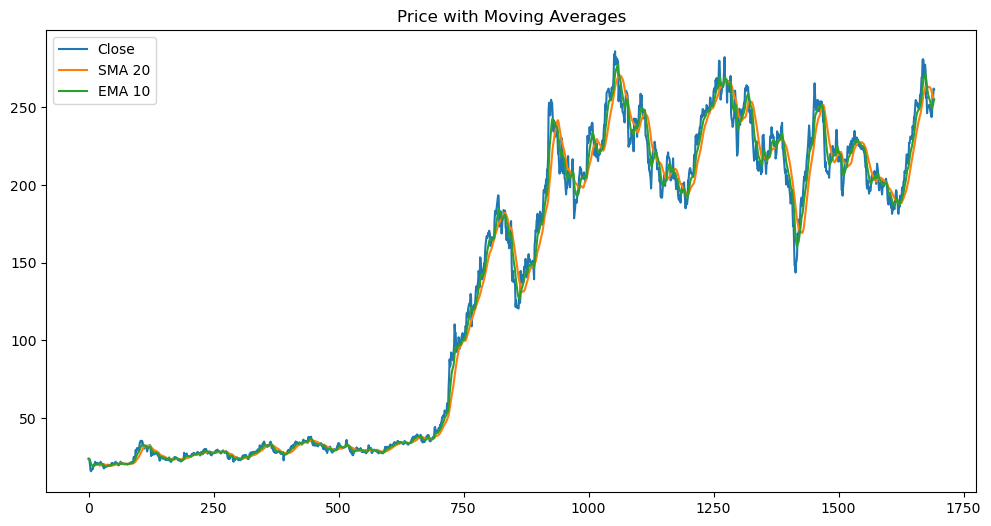

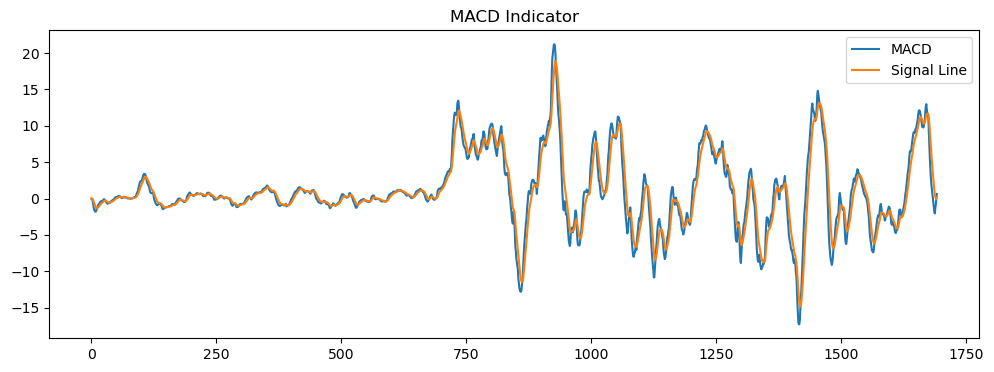

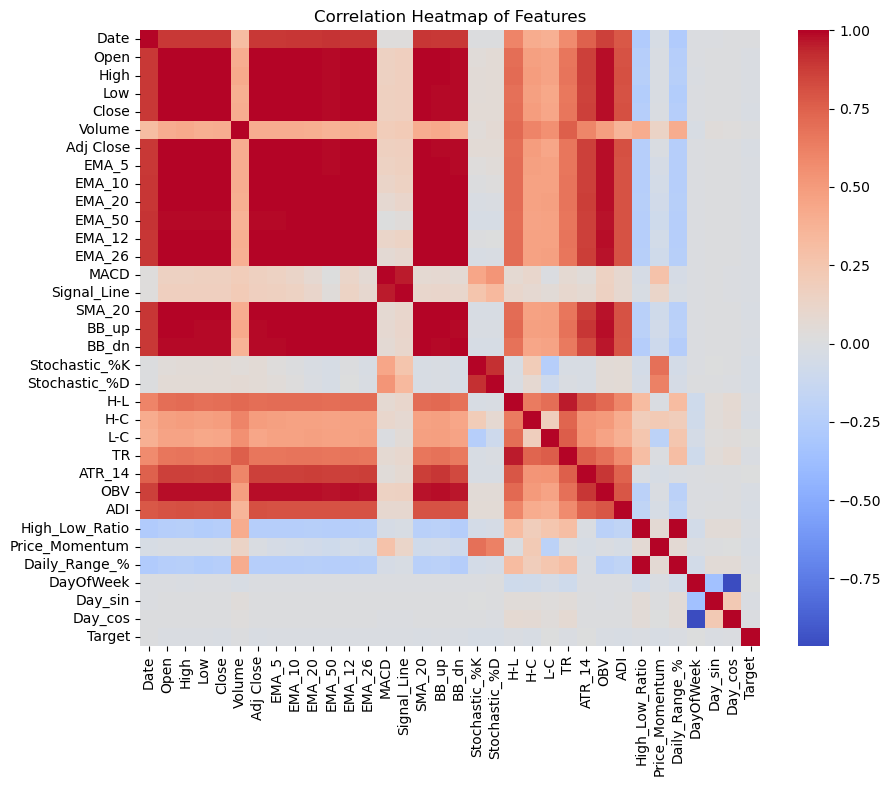

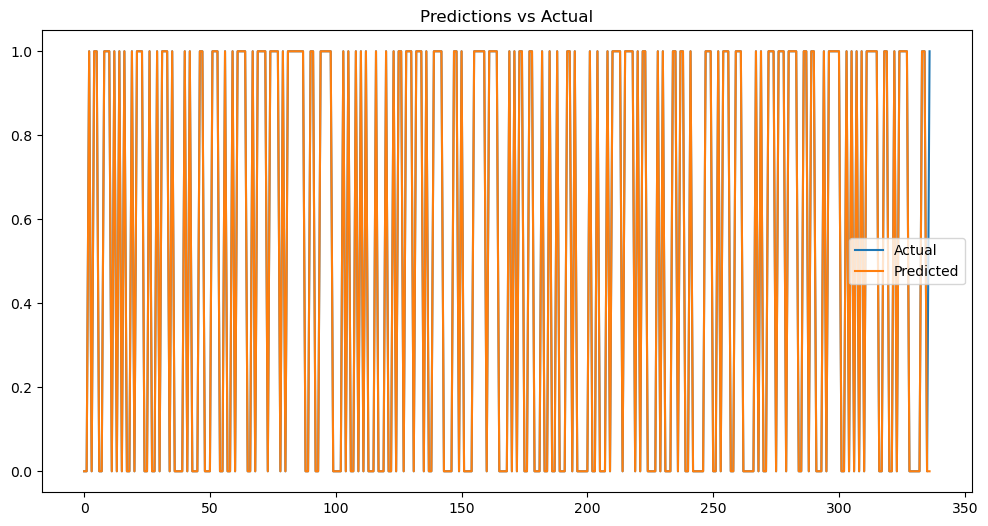

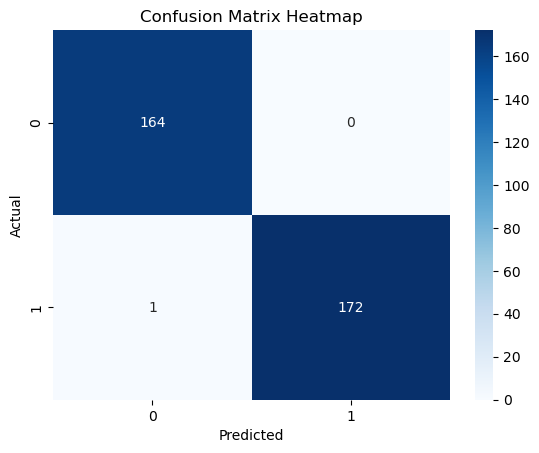

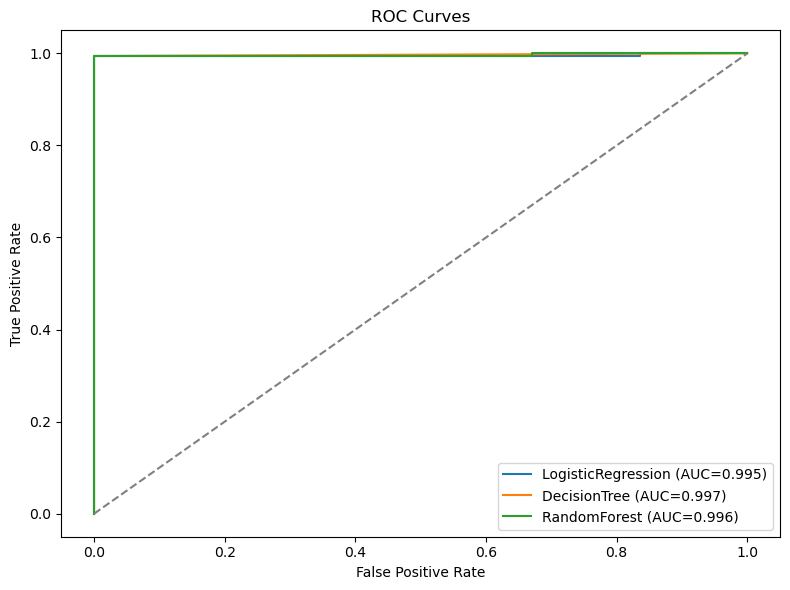

In [49]:
#all the plots
# Plot Rolling averages vs Price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['EMA_10'], label='EMA 10')
plt.legend(); plt.title("Price with Moving Averages"); plt.show()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(data['MACD'], label='MACD')
plt.plot(data['Signal_Line'], label='Signal Line')
plt.legend(); plt.title("MACD Indicator"); plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()

# Predictions vs Actual (example after model prediction)
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend(); plt.title("Predictions vs Actual"); plt.show()

# Confusion matrix as heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# 10. Plot ROC curves (if predict_proba available)
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plotted = False
for name, model in models.items():
    try:
        probs = model.predict_proba(Xte_num)[:,1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
        plotted = True
    except Exception as e:
        print("No predict_proba for", name, ":", e)
if plotted:
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("None of the models provided probability estimates.")

Top features per model:

Logistic Regression (top coef):


Open                  0.894083
Low                   0.460277
High                  0.444958
Close_minus_SMA_20    0.269079
Return                0.162822
Volume_SMA_5          0.106695
Momentum_5            0.080657
RollStd_10            0.058113
Volume_SMA_10         0.030726
RollStd_5             0.013192
dtype: float64


Decision Tree importances:


RSI_14           0.271441
Momentum_5       0.242054
Open             0.183429
Volume_SMA_5     0.155954
Volume_SMA_10    0.108356
RollStd_10       0.038766
Return           0.000000
Adj Close        0.000000
Volume           0.000000
High             0.000000
dtype: float64


Random Forest importances:


RSI_14                0.070220
RollStd_10            0.054303
Volume_SMA_5          0.052694
Momentum_5            0.050721
Volume_change         0.050338
High-Low              0.041704
Close_minus_SMA_20    0.041592
Close_minus_SMA_10    0.040105
Return_lag_2          0.039440
Return_lag_5          0.038955
Volume                0.037080
Volume_SMA_10         0.035391
dtype: float64

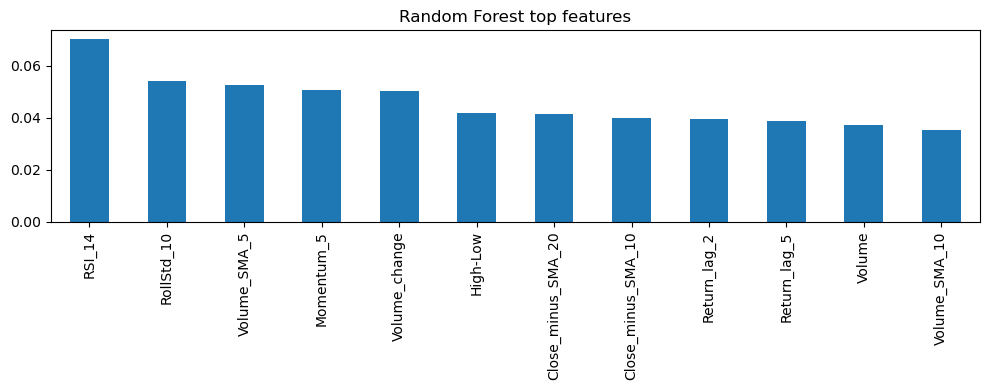

In [68]:
# 11. Feature importance & logistic coefficients
# ---------------------------------------------------------
print("Top features per model:")

# Logistic coefficients (after scaling) -> feature names numeric_cols
lr_clf = best_log.named_steps['clf']
coefs = pd.Series(lr_clf.coef_.ravel(), index=numeric_cols).sort_values(ascending=False)
print("\nLogistic Regression (top coef):")
display(coefs.head(10))

# Decision Tree importances
dt_clf = best_tree.named_steps['clf']
if hasattr(dt_clf, 'feature_importances_'):
    fi_dt = pd.Series(dt_clf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
    print("\nDecision Tree importances:")
    display(fi_dt.head(10))

# Random Forest importances
rf_clf = best_rf.named_steps['clf']
if hasattr(rf_clf, 'feature_importances_'):
    fi_rf = pd.Series(rf_clf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
    print("\nRandom Forest importances:")
    display(fi_rf.head(12))
    # plot
    plt.figure(figsize=(10,4))
    fi_rf.head(12).plot(kind='bar')
    plt.title('Random Forest top features')
    plt.tight_layout()
    plt.show()
    

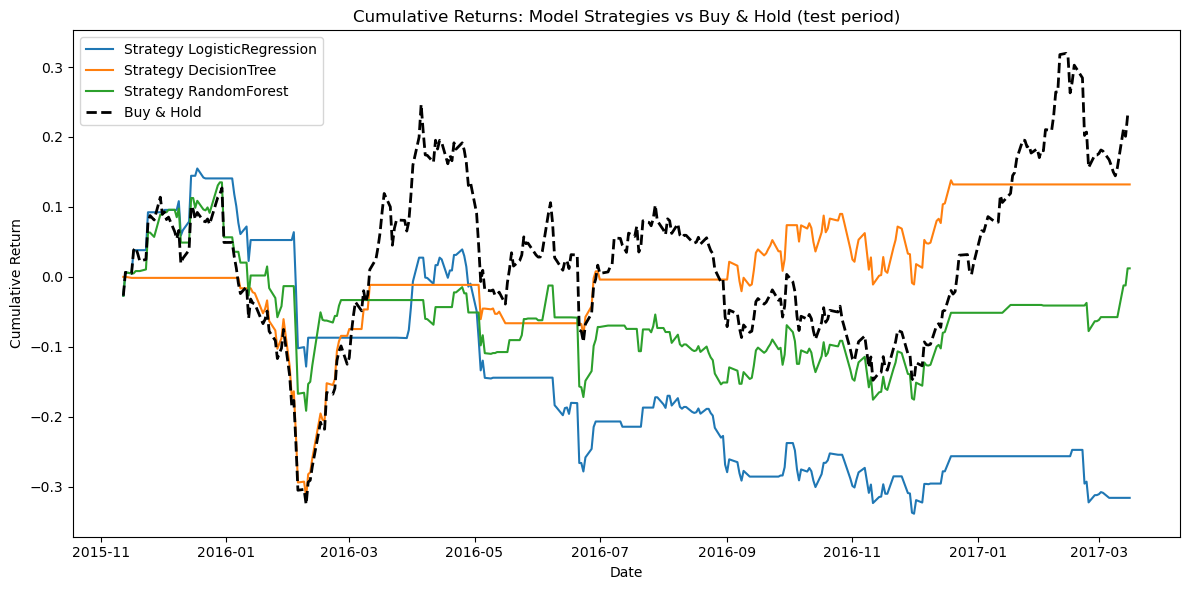

Final cumulative returns over test period: {'LogisticRegression': -0.3159018056963314, 'DecisionTree': 0.1321295701315297, 'RandomForest': 0.01215690012068138, 'BuyHold': 0.22804544728049603}
Cohen Kappa: 0.029641929728488448
MCC: 0.029760822278247893


In [69]:
# 12. Simple backtest of model-based strategy vs buy-and-hold
# ---------------------------------------------------------
# Build a test period dataframe with true next-day returns
test_data = xeroxdata.iloc[split_idx:].reset_index(drop=True).copy()
# we already computed Next_Return earlier as (Next_Close/Close - 1)
test_data['Next_Return'] = (test_data['Next_Close'] / test_data['Close']) - 1

for name, model in models.items():
    test_data[f'pred_{name}'] = model.predict(Xte_num)
    # long-only strategy: if prediction == 1 => take next day's return, else 0
    test_data[f'strategy_ret_{name}'] = test_data[f'pred_{name}'] * test_data['Next_Return']

# buy & hold return (holding through next day)
test_data['hold_ret'] = test_data['Next_Return']

# cumulative returns
for name in models.keys():
    test_data[f'cum_strategy_{name}'] = (1 + test_data[f'strategy_ret_{name}']).cumprod() - 1
test_data['cum_hold'] = (1 + test_data['hold_ret']).cumprod() - 1

# plot
plt.figure(figsize=(12,6))
for name in models.keys():
    plt.plot(test_data['Date'], test_data[f'cum_strategy_{name}'], label=f"Strategy {name}")
plt.plot(test_data['Date'], test_data['cum_hold'], label='Buy & Hold', lw=2, ls='--', c='k')
plt.legend()
plt.title('Cumulative Returns: Model Strategies vs Buy & Hold (test period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.tight_layout()
plt.show()

# final cumulative returns for summary:
final_returns = {name: float(test_data[f'cum_strategy_{name}'].iloc[-1]) for name in models.keys()}
final_returns['BuyHold'] = float(test_data['cum_hold'].iloc[-1])
print("Final cumulative returns over test period:", final_returns)

print("Cohen Kappa:", cohen_kappa_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

In [70]:
# 13. Save artifacts (models and processed files)
# ---------------------------------------------------------
ARTIFACT_DIR = "artifacts"
# Save best pipelines and processed datasets for submission
joblib.dump(best_log, os.path.join(ARTIFACT_DIR, "best_logistic_pipeline.joblib"))
joblib.dump(best_tree, os.path.join(ARTIFACT_DIR, "best_tree_pipeline.joblib"))
joblib.dump(best_rf, os.path.join(ARTIFACT_DIR, "best_rf_pipeline.joblib"))

data.to_csv(os.path.join(ARTIFACT_DIR, "tesla_processed_full.csv"), index=False)
test_data.to_csv(os.path.join(ARTIFACT_DIR, "tesla_processed_test.csv"), index=False)

# Save results summary
import json
with open(os.path.join(ARTIFACT_DIR, "results_summary.json"), "w") as f:
    json.dump(results, f, indent=4)

print("Saved models and processed data into:", ARTIFACT_DIR)


Saved models and processed data into: artifacts


In [72]:
# 14. Conclusions (print a concise summary)
# ---------------------------------------------------------
print("Evaluation conclusion:")
for k,v in results.items():
    print(f"{k}: Accuracy={v['accuracy']:.4f} Precision={v['precision']:.4f} Recall={v['recall']:.4f} F1={v['f1']:.4f} ROC-AUC={v['roc_auc']:.4f}")


Summary of evaluation metrics (on test set):
LogisticRegression: Accuracy=0.4629 Precision=0.4740 Recall=0.4220 F1=0.4465 ROC-AUC=0.4438
DecisionTree: Accuracy=0.5045 Precision=0.5250 Recall=0.3642 F1=0.4300 ROC-AUC=0.4980
RandomForest: Accuracy=0.5163 Precision=0.5266 Recall=0.5723 F1=0.5485 ROC-AUC=0.4927
